## 参考資料
- [詳細確率ロボティクスのgit](https://github.com/ryuichiueda/LNPR_BOOK_CODES)
- [同時確率と条件付確率については「PFNのChainerチュートリアル6章」がかなり分かりやすい](https://tutorials.chainer.org/ja/06_Basics_of_Probability_Statistics.html#)

In [ ]:
# conect to drive on colab
from google.colab import drive
drive.mount("/content/drive")

dir_path="./drive/MyDrive/Colab Notebooks/ProbabilisticRobotics/"

# dir_path="./"



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data=pd.read_csv(dir_path+"sensor_data/sensor_data_200.txt",delimiter=" ",header=None,names=("data","time","ir","lidar"))
data

,data,time,ir,lidar
0,20180122,95819,305,214
1,20180122,95822,299,211
2,20180122,95826,292,199
3,20180122,95829,321,208
4,20180122,95832,298,212
...,...,...,...,...
58983,20180124,120023,313,208
58984,20180124,120026,297,200
58985,20180124,120030,323,204
58986,20180124,120033,326,207


mean 209.73713297619855 var 23.4077097702742 unbiased_var 23.408106598554504 std 4.838192492920729


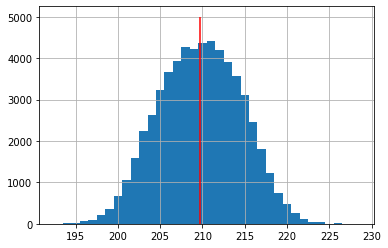

In [ ]:
# lidarのヒストグラム
data["lidar"].hist(bins=max(data["lidar"])-min(data["lidar"]),align="left")

# 平均
plt.vlines(data["lidar"].mean(),ymin=0,ymax=5000,color="red")


# 分散
mean=data["lidar"].mean()
var=np.var(data["lidar"])
unbiased_var=np.var(data["lidar"],ddof=1)
std=data["lidar"].std()

print("mean",mean,"var",var,"unbiased_var",unbiased_var,"std",std)

1.0


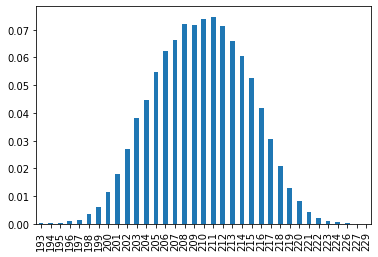

In [ ]:
# 素朴な確率分布
# 素朴とは全データN個にある値がm個含まれるときのその値を得る確率のこと
# これは離散値を仮定しており、Lidarのデータは有限の桁数を持つ離散値だからこれで確率を得られる
# 余談だけど、一般的な書物は厳密な定義を求めてから現実のデータに合わせて離散化することが多い
# この本はいきなり現実の値を扱うから全く逆の順序で進んでいるが、数式にとらわれず直感的にも理解しやすいのでこれはこれで良い
# なお、離散値で確率を得る関数のことを確率質量関数という
# 連続値の場合は確率密度関数になる(後述)

freqs=pd.DataFrame(data["lidar"].value_counts())
freqs["probs"]=freqs["lidar"]/len(data["lidar"])

# print(freqs)
print(freqs["probs"].sum())
freqs["probs"].sort_index().plot.bar()


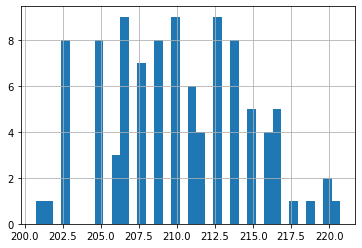

In [ ]:
# 確率分布のシミュレーション

# ドローイング用の関数
# ドローイングとサンプリングは区別する
# ドローイングは確率分布を加味して1つの値を取り出す
# サンプリングは母集団の中から完全ランダムに1つの値を取り出す
def drawing():
    return freqs.sample(n=1,weights="probs").index[0]

#これでヒストグラム作ってみる
# samples=[drawing() for i in range(len(data))]
samples=[drawing() for i in range(100)]#全数とると処理重いんで適当に100点プロット
simulated=pd.DataFrame(samples,columns=["lidar"])
simulated["lidar"].hist(bins=max(data["lidar"])-min(data["lidar"]),align="left")


## ガウス分布
f(X) = $\frac{1}{\sqrt{2πσ^2}}\exp{[-\frac{(x-μ)^2}{2σ^2}]}$

なお、
$u$:平均
$σ^2$:分散

- ガウス分布がよく使われる背景には、中心極限定理がある
- 中心極限定理とはざっくりいうと、「母集団がどのような分布を持っていても，そこから取り出した標本の算術平均はデータ数
nが十分大きいときに正規分布にしたがう」という定理
- 母集団がどのような分布を持っていても従うというのが奇妙だが数学的に証明されている


209.73713297619855 23.4077097702742


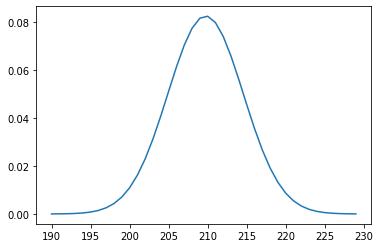

In [ ]:
# 確率モデル

#ガウス分布

def p(z,mu,dev):
    return np.exp(-(z-mu)**2/(2*dev))/np.sqrt(2*np.pi*dev)

mean=data["lidar"].mean()
dev=np.var(data["lidar"])
print(mean,dev)

zs=range(190,230)
ys=[p(z,mean,dev) for z in zs]

plt.plot(zs,ys)


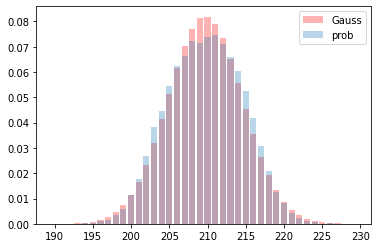

In [ ]:

#確率密度関数のプロット

# さっきの確率質量関数と違って連続地を扱える
# 連続値
# 区間[x-0.5,x+0.5)で積分([a,b)はa以上b未満を表す)
# ただしここでは台形公式で近似
def prob(z,width=0.5):
    return width*(p(z-width)+p(z+width))

zs=range(190,230)
ys=[prob(z) for z in zs]
plt.bar(zs,ys,color="red",alpha=0.3,label="Gauss")

f=freqs["probs"].sort_index()
plt.bar(f.index,f.values,alpha=0.3,label="prob")
plt.legend()

## 確率質量関数と確率密度関数
- 確率質量関数
  - 離散的な値に用いる
- 確率密度関数
  - 連続的な値に用いる
    - 例えばLidarセンサーの値が200ぴったしの確率は0である。なぜなら200.000001かもしれないから
    - よって、値に幅を持たせる
    - この幅を微小にして微分したものが確率密度関数
- 確率密度関数は体積と質量の関係と同じ
- 物質の座標1点を取り出しても質量は0であるが塊だと0ではない
- これは密度によって解釈できる
- ある物質のある座標xの密度をρ(x)とすると物体の一部Aと質量mの関係は以下になる

$m=\int_{x\in A}^{}ρ(x)dx$

- よって、ρがいくら大きくてもx一点で計算すると積分が0になる=質量が0になる

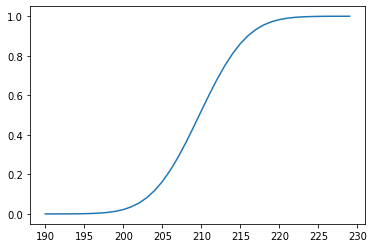

In [ ]:
#累積分布関数
# norm.pdfだと確率密度関数になる
from scipy.stats import norm
zs=range(190,230)
ys=[norm.cdf(z,mean,stddev) for z in zs]
plt.plot(zs,ys)



## 累積分布関数から確率分布を描く
- 先ほど台形公式で近似した部分をきちんと積分すると確率の差に置き換え可能
$$
\begin{align}
P(a\leq z < b) &= \int_{a}^{b} p(z)dz\\
&= \int_{-\infty}^{b} p(z)dz - \int_{a}^{-\infty} p(z)dz\\
&= P(z<b)-P(z<a)
\end{align}
$$

<BarContainer object of 40 artists>

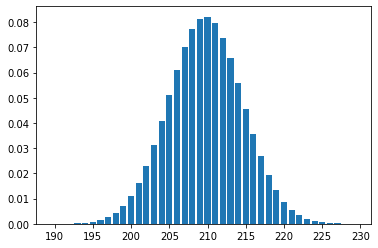

In [ ]:
#累積分布関数から確率分布を描く
zs=range(190,230)
ys=[norm.cdf(z+0.5,mean,stddev) - norm.cdf(z-0.5,mean,stddev) for z in zs]
plt.bar(zs,ys)


## 期待値
離散
$$
\sum_{z=-\infty}^{\infty} zP(z)
$$
連続
$$
\int_{-\infty}^{\infty} zp(z)dz
$$

- つまり、具体的な値が決まっていなくても以上の分布の式から期待値を計算可能
- 例えば6面サイコロの場合
$$
\sum_{x=1}^{6} x\frac{1}{6} = \frac{21}{6} = 3.5$$

- 逆に何度もドローイングして平均をとって期待値の近似値を求めることも可能


In [ ]:
# 期待値
import random
samples=[random.choice([1,2,3,4,5,6]) for i in range(1000000)]
sum(samples)/len(samples)

3.502131

## 条件付確率と同時確率
- 条件付確率
  - 条件付けをした上で求めた確率
  - 一般には$P(y|x)$
  - 具体例を挙げると、6時台のセンサー値の確率分布は$P(z|t\in 6時台)$
    - z=センサ値、t=時刻
- 同時確率(jpint probability)
  - 2つ以上の条件が同時に満たされる時の確率
  - 具体例：$p(z=620,t=6)$

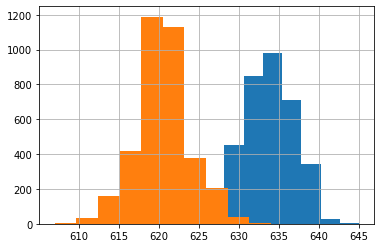

In [ ]:
# 条件付き確率
data=pd.read_csv(dir_path+"sensor_data/sensor_data_600.txt",delimiter=" ",header=None,names=("data","time","ir","lidar"))
# data["lidar"].hist(bins=max(data["lidar"])-min(data["lidar"]),align="left")

# data["lidar"].plot()
# plt.ylim(600,650)

data["hour"]=[time//10000 for time in data.time]
d=data.groupby("hour")
# d.lidar.mean().plot()

d.lidar.get_group(6).hist()#6時台のデータ
d.lidar.get_group(14).hist()#14時台のデータ



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


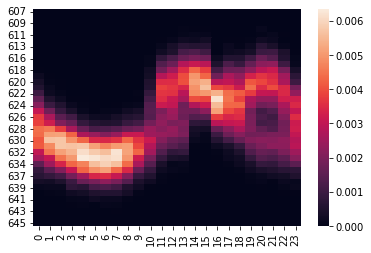

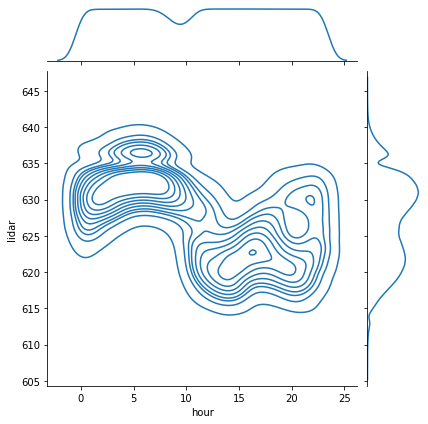

In [ ]:
# 同時確率
each_hour={i:d.lidar.get_group(i).value_counts().sort_index() for i in range(24)}# dataframe for each hour
freqs = pd.concat(each_hour,axis=1)
freqs=freqs.fillna(0)
probs=freqs/len(data)

import seaborn as sns
sns.heatmap(probs)

sns.jointplot(data["hour"],data["lidar"],data,kind="kde")
plt.show()

## 時間ごとの確率とセンサ値ごとの確率の表現
$$
P(t)=\sum_{z}{} P(z,t)\\
P(z)=\sum_{t}{} P(z,t)
$$
- 上の式の意味
  - zとtの同時確率について、全部のzについての確率を足したらただのtについての確率になる
  - 逆もまた然り
- グラフとの対応
  - sns.jointplotで出てきたグラフが対応
  - 上のグラフが$P(t)$の確率分布
  - 右のグラフが$P(z)$の確率分布
- 次のプロットで式が成り立つことを確認

0    1.0
dtype: float64
0    1.0
dtype: float64


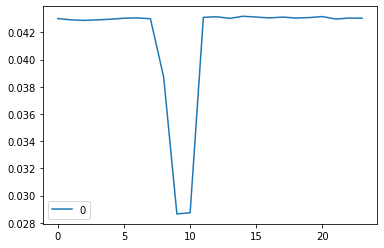

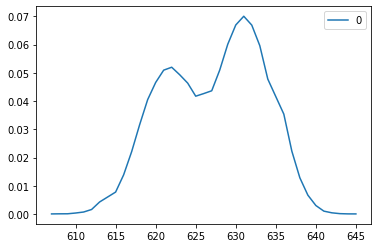

In [ ]:
# 同時確率の各条件の合計をプロット
# 時間合計をプロット
# sns.jointplotの上のグラフに対応するはず
p_t=pd.DataFrame(probs.sum())
p_t.plot()
print(p_t.sum())

# 測定値合計をプロット
# sns.jointplotの右のグラフに対応するはず
p_z=pd.DataFrame(probs.transpose().sum())
p_z.plot()
print(p_z.sum())

## 周辺確率
- 以上の、同時確率の片方の条件について全部足せば、もう片方の条件の確率(同時確率でなくただの1変数についての確率)と等しくなるというのは一般に言えることである
- 式を一般化すると以下になる
$$
P(x)=\sum_{y\in γ}{}P(x,y)\\
(γ:yの定義域)
$$

- これは離散値に対してなので、連続値の変数$x,y \in R$に対しては積分で考える
$$
p(x)=\int_{-\infty}^{\infty} p(x,y)dy
$$

- この関係のことを確率の加法定理という
- また、P(x,y)からP(x)やP(y)を得るというのは情報を削っている(または次元を落としている)と言える
- このように得られた確率のことを周辺確率といい、この操作を周辺化、得られた確率分布を周辺確率分布という
- この本では周辺化を表す記号として以下を用いる
$$
\lbrack f(x,y)\rbrack _y = \sum_{y\in γ} f(x,y) \\
\lbrack f(x,y\rbrack _y = \int_{-\infty}^{\infty} f(x,y)dy
$$
よって
$$
P(x) = \lbrack f(x,y)\rbrack _y \\
p(x) = \lbrack f(x,y\rbrack _y 
$$
と表現できる


## 同時確率と条件付確率の関係
- まず、同時確率と条件付確率は似ているけど違うものという復習
  - 条件付確率とは例えばある時刻tを固定して始めてzの確率が求められるというもの
    - つまり片方の条件を固定してもう片方の情報を得る
  - 同時確率とは2変数の確率を同時に考えるもの
    - 2つの確率の分布を二次元分布として考えるもの
    - 
- 同時確率と条件付確率の関係

$$
P(z|t)=P(z,t)/P(t)・・・①\\
P(z,t)=P(z|t)P(t)・・・②
$$

-  最初の復習から$P(z|t) > P(z,t)$であることは直感的に分かると思うので、この式もなんとなく分かると思う
   -  ①はP(t)が決まることで同時確率に条件が付いて確率が上がって条件付確率となる
   -  ②は条件付確率にP(t)をかけることでtが決まっていない状態の確率(=同時確率)になる
- これを一般に確率の乗法定理という
$$
P(z,y)=P(x|y)P(y)=P(y|x)P(x)
$$
- また、この式を用いると周辺化の確率を次のように表現できる
$$
P(x) = \lbrack P(x,y)\rbrack_y = \lbrack P(x|y)P(y)\rbrack_y = \lt P(x|y)\gt\gt_P(y)\\
p(x) = \lbrack p(x,y)\rbrack_y = \lt p(x|y)\gt\gt_p(y)
$$


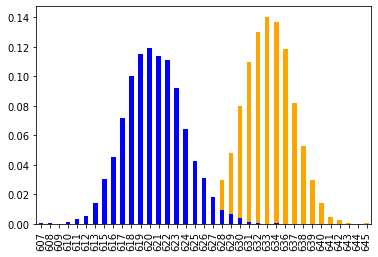

In [ ]:
# 同時確率と条件付確率の関係式が正しいのかチェック
# P(z|t)=P(z,t)/P(t)
cond_z_t=probs/p_t[0]
cond_z_t[6].plot.bar(color="orange")
cond_z_t[14].plot.bar(color="blue")


## 独立と従属、条件付き独立
- 乗法定理の式　$P(x,y)=P(x|y)P(y)$　においてxとyが独立である場合、いかが成り立つ。
$$
P(x|y) = P(x)
$$

- また、このとき以下が成り立つ。
$$
P(x,y) = P(x) P(y)
$$

- なお、独立の表現は$x⫫y$と表し、独立でない場合を従属という。
- この本では光センサyとLidarセンサの値zの比較を後ほど扱うが、全時間においては片方が大きく片方が小さいものの、ある時間帯に限るとその関係が見られない部分(独立な部分)がある。
- これを条件付き独立といい$y⫫z|t$と表記する。
- 条件付き独立が成り立つ場合、一般に以下が成り立つ。
$$
P(z,y|t) = P(z|t) P(y|t)
$$


## 確率分布の性質を利用した計算
- 以上の加法定理、乗法定理、独立を利用すると積分計算が簡単になることがある。
- 例えば、$x⫫y,x\in R,y\in R$であるとき、
$$
z=
\begin{pmatrix}
x  \\
y
\end{pmatrix}
$$
というベクトル$z \in R^2$を考える
- 